## 1. Defs 

In [1]:
import numpy as np
from scipy import optimize
from scipy import interpolate
import h5py
#from mpi4py import MPI
from time import time


def LoadAndResample(filename, times):
    wave = filename
    hp = interpolate.InterpolatedUnivariateSpline(times, wave.real, k=3)
    hpinterp = hp(times)
    hc = interpolate.InterpolatedUnivariateSpline(times, wave.imag, k=3)
    hcinterp = hc(times)
    i = np.abs(times).argmin()
    hp_0=wave[i].real
    hc_0=wave[i].imag
    phi = np.arctan2(hc_0,hp_0)
    A = np.sqrt(hp_0*hp_0+hc_0*hc_0)
    c = np.cos(-phi)/A
    s = np.sin(-phi)/A
    return (c*hpinterp-s*hcinterp) + 1.0j*(c*hcinterp+s*hpinterp)


def LoadAndAlignToPrevious(filename, existing, times):
    newwave = LoadAndResample(filename, times)
    op = optimize.fmin_tnc(f, np.array([0, 0]), args = (newwave, existing, times), approx_grad=1, bounds=((-np.pi, np.pi), (-10.0, 10.0)), messages=0)
    [deltaPhi, deltaT] = op[0]
    newwave = timephaseshift(newwave, times, deltaPhi, deltaT)
    return newwave


# Function to time and phase shift waveform
def timephaseshift(wave, times, deltaPhi, deltaT):
    tvals = times + deltaT
    hp = interpolate.InterpolatedUnivariateSpline(times, wave.real.astype('float64'), k=3)
    hpinterp = hp(tvals)
    hc = interpolate.InterpolatedUnivariateSpline(times, wave.imag.astype('float64'), k=3)
    hcinterp = hc(tvals)
    return (np.cos(deltaPhi) * hpinterp - np.sin(deltaPhi) * hcinterp) + 1.0j*(np.cos(deltaPhi) * hcinterp + np.sin(deltaPhi) * hpinterp)


# Function to be minimized
def f(x, waveA, waveB, times):
    deltaPhi = x[0]
    deltaT = x[1]
    shifted = timephaseshift(waveA, times, deltaPhi, deltaT)
    return -Match(shifted, waveB, times)


# Inner product between two waveforms assuming flat PSD
def InnerProduct(waveA, waveB, times):
    ans = 0.0
    dT = times[1:]-times[:-1]
    return np.sum(dT*(waveA[:-1].real*waveB[:-1].real + waveA[:-1].imag*waveB[:-1].imag))


# Match between two waveforms assuming flat PSD
def Match(waveA, waveB, times):
    AB = InnerProduct(waveA, waveB, times)
    AA = InnerProduct(waveA, waveA, times)
    BB = InnerProduct(waveB, waveB, times)
    return (AB/np.sqrt(AA*BB))


def align_normalize_and_match(wfl, wfp, times):
    
    # Align
    #wfl = LoadAndResample(wfl, times)
    #wfp = LoadAndAlignToPrevious(wfp, wfl, times)
    
    # Ground Truth Normalization
    maxidx = np.argmax(wfl.real**2 + wfl.imag**2) # Finds index of peak amplitude.
    norm_one = (wfl.real[maxidx]**2 + wfl.imag[maxidx]**2)**0.5
    wfl.real, wfl.imag = wfl.real/norm_one, wfl.imag/norm_one
    
    
    # Predicted Normalization
    maxidx = np.argmax(wfp.real**2 + wfp.imag**2) # Finds index of peak amplitude.
    norm_one = (wfp.real[maxidx]**2 + wfp.imag[maxidx]**2)**0.5
    wfp.real, wfp.imag = wfp.real/norm_one, wfp.imag/norm_one
    
    return wfl,wfp,Match(wfl, wfp, times)

## 2. Load Data

In [2]:
#checkpoint_dir = '../../../checkpoint/fixed_embed_2M_transfromer_minus60/'
checkpoint_dir='/projects/bbke/victoria/Signal_forecasting/transformer/training/lightning/inference/'

r_predictions = np.load(checkpoint_dir+'r_predictions.npy')#[:,:,0]
r_targets = np.load(checkpoint_dir+'r_targets.npy')#[:,:,0]
r_params = np.load(checkpoint_dir+'params.npy')

c_predictions = np.load(checkpoint_dir+'c_predictions.npy')#[:,:,1]
c_targets = np.load(checkpoint_dir+'c_targets.npy')#[:,:,1]
#c_predictions = np.load(checkpoint_dir+'c_predictions.npy').squeeze(axis=-1)
#c_targets = np.load(checkpoint_dir+'c_targets.npy').squeeze(axis=-1)
c_params = np.load(checkpoint_dir+'params.npy')

In [3]:
'''#checkpoint_dir = '../../../checkpoint/fixed_embed_2M_transfromer_minus60/'
checkpoint_dir='/home/neuron/GW/inference/'

r_predictions = np.load(checkpoint_dir+'predicted_waveforms.npy')[0,:]
r_targets = np.load(checkpoint_dir+'true_waveforms.npy')[0,:]
r_params = np.load(checkpoint_dir+'parameters.npy')

c_predictions = np.load(checkpoint_dir+'predicted_waveforms.npy')[1,:]
c_targets = np.load(checkpoint_dir+'true_waveforms.npy')[1,:]
#c_predictions = np.load(checkpoint_dir+'c_predictions.npy').squeeze(axis=-1)
#c_targets = np.load(checkpoint_dir+'c_targets.npy').squeeze(axis=-1)
c_params = np.load(checkpoint_dir+'parameters.npy')'''

"#checkpoint_dir = '../../../checkpoint/fixed_embed_2M_transfromer_minus60/'\ncheckpoint_dir='/home/neuron/GW/inference/'\n\nr_predictions = np.load(checkpoint_dir+'predicted_waveforms.npy')[0,:]\nr_targets = np.load(checkpoint_dir+'true_waveforms.npy')[0,:]\nr_params = np.load(checkpoint_dir+'parameters.npy')\n\nc_predictions = np.load(checkpoint_dir+'predicted_waveforms.npy')[1,:]\nc_targets = np.load(checkpoint_dir+'true_waveforms.npy')[1,:]\n#c_predictions = np.load(checkpoint_dir+'c_predictions.npy').squeeze(axis=-1)\n#c_targets = np.load(checkpoint_dir+'c_targets.npy').squeeze(axis=-1)\nc_params = np.load(checkpoint_dir+'parameters.npy')"

In [4]:
predictions = r_predictions + 1j*r_predictions
targets = r_targets + 1j*r_targets
params = r_params

In [5]:
'''predictions=predictions[:,0,:]
targets=targets[:,0,:]
params=params[:,0,:]'''

'predictions=predictions[:,0,:]\ntargets=targets[:,0,:]\nparams=params[:,0,:]'

In [6]:
targets.shape

(496, 115, 1)

In [7]:
N=predictions.shape[0]

## 3. Compute Match 

#### a) Single Example 

In [8]:
import matplotlib.pyplot as plt

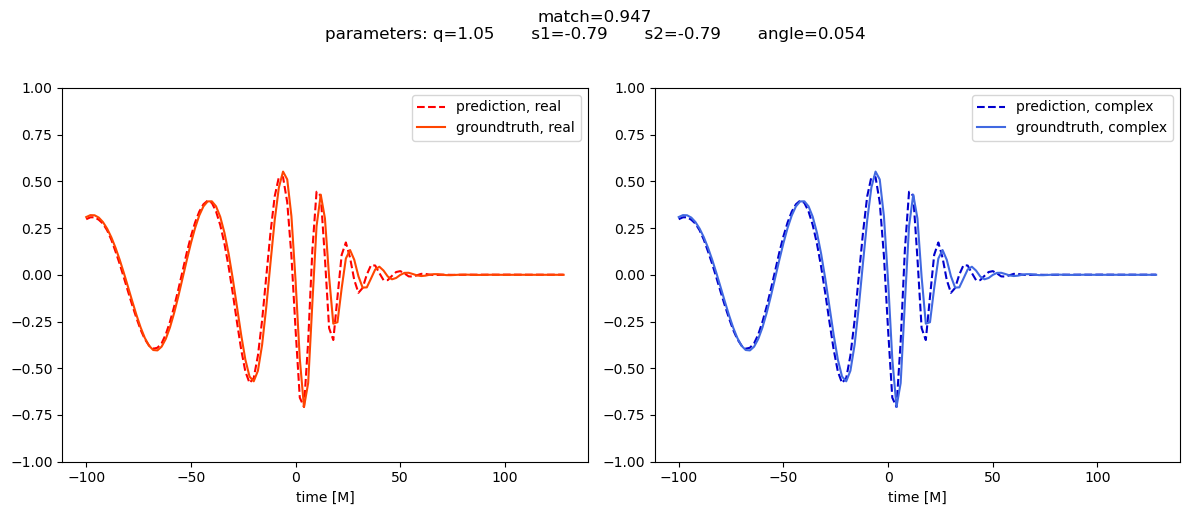

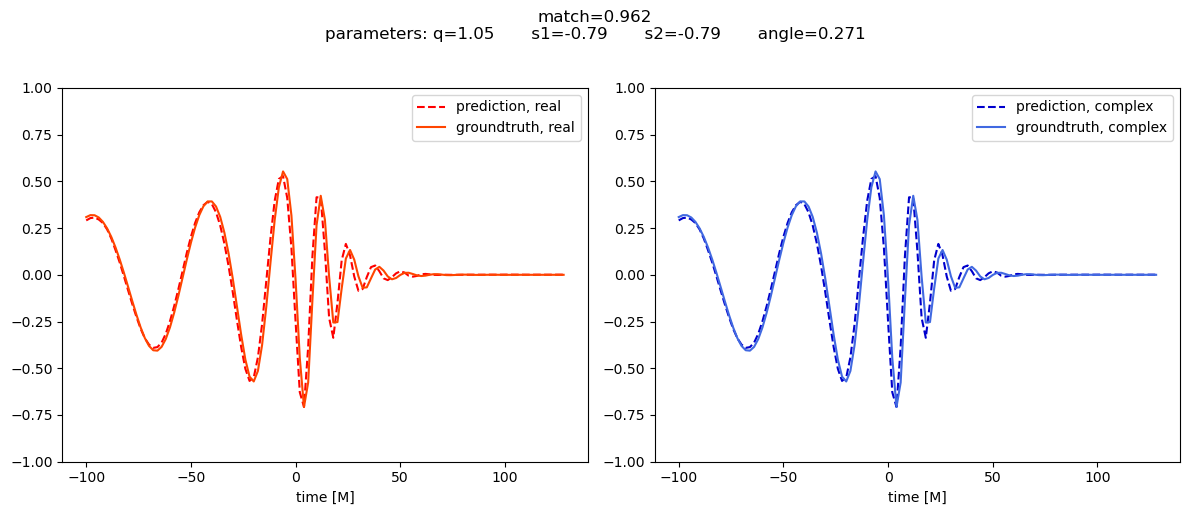

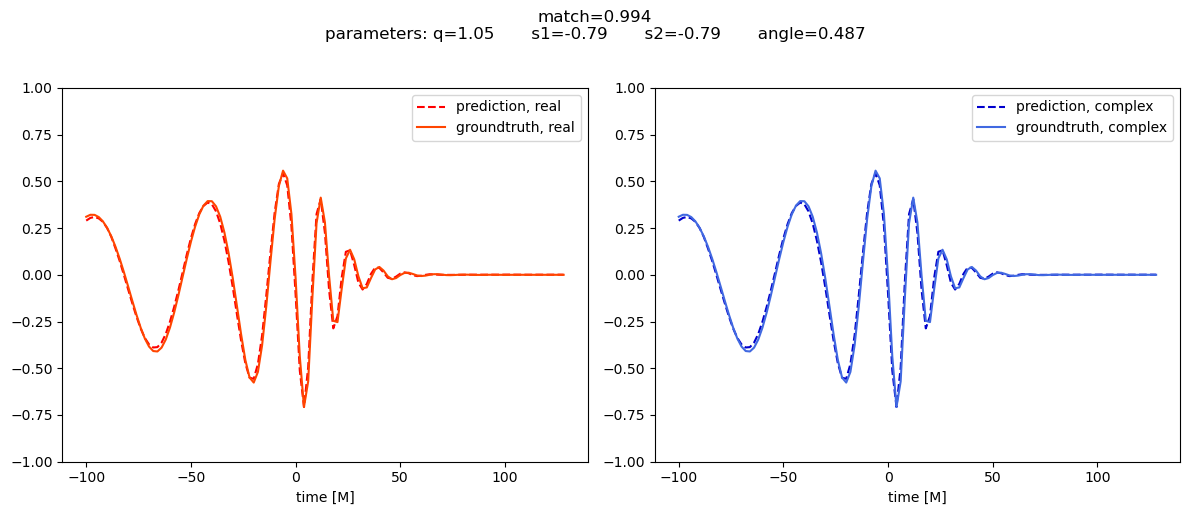

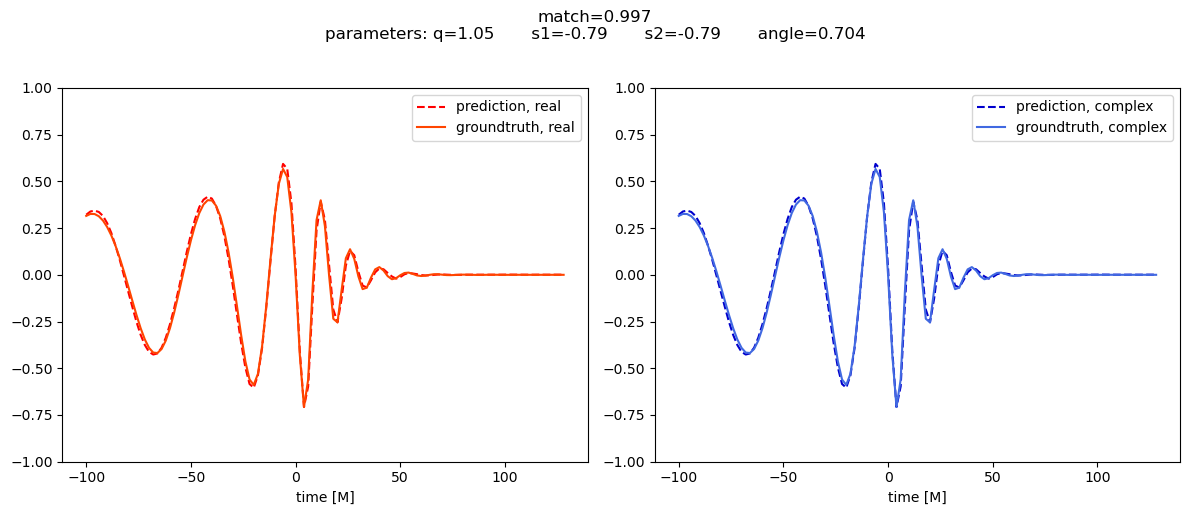

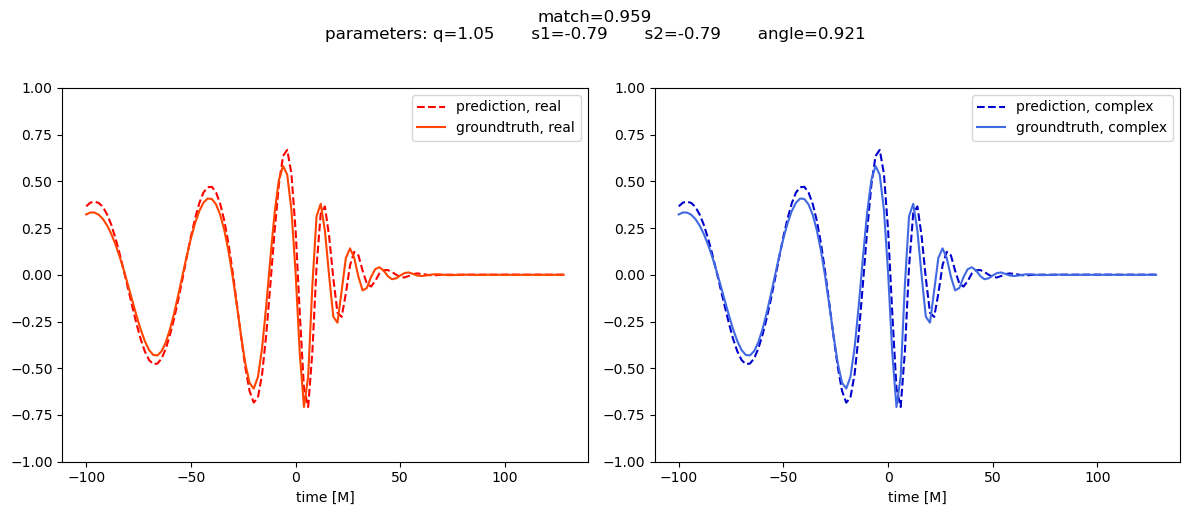

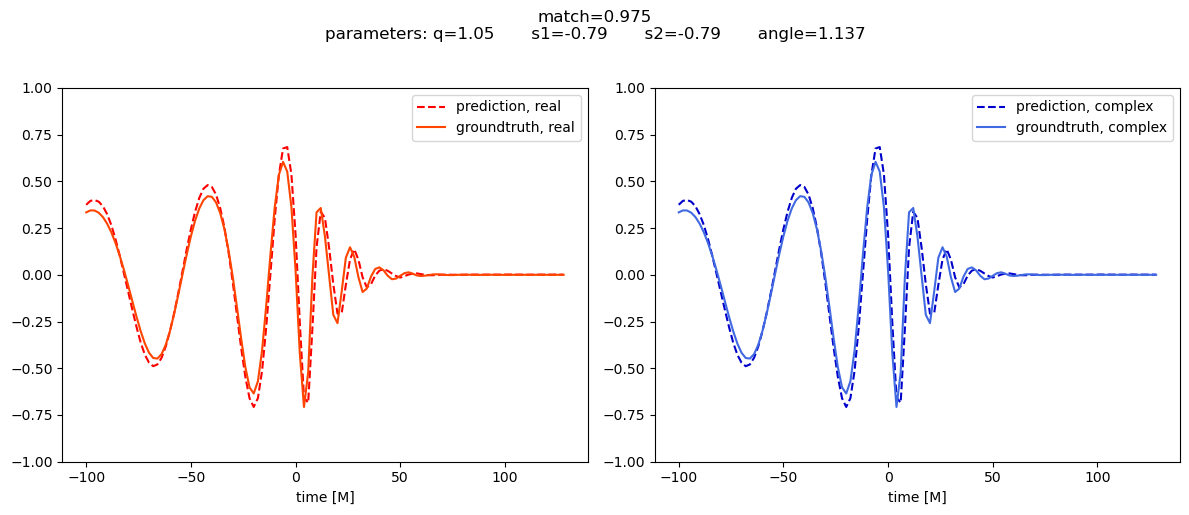

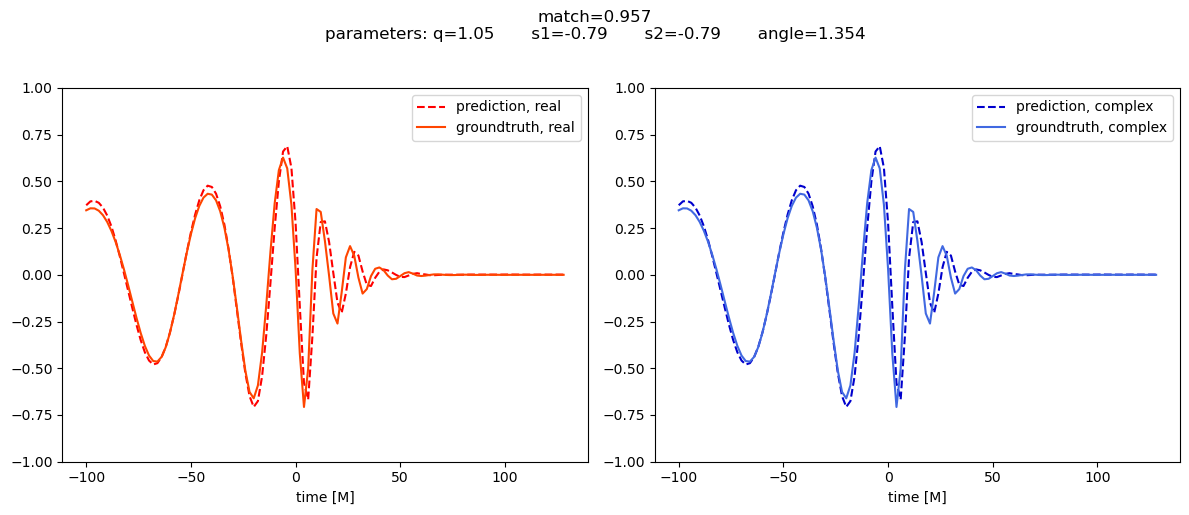

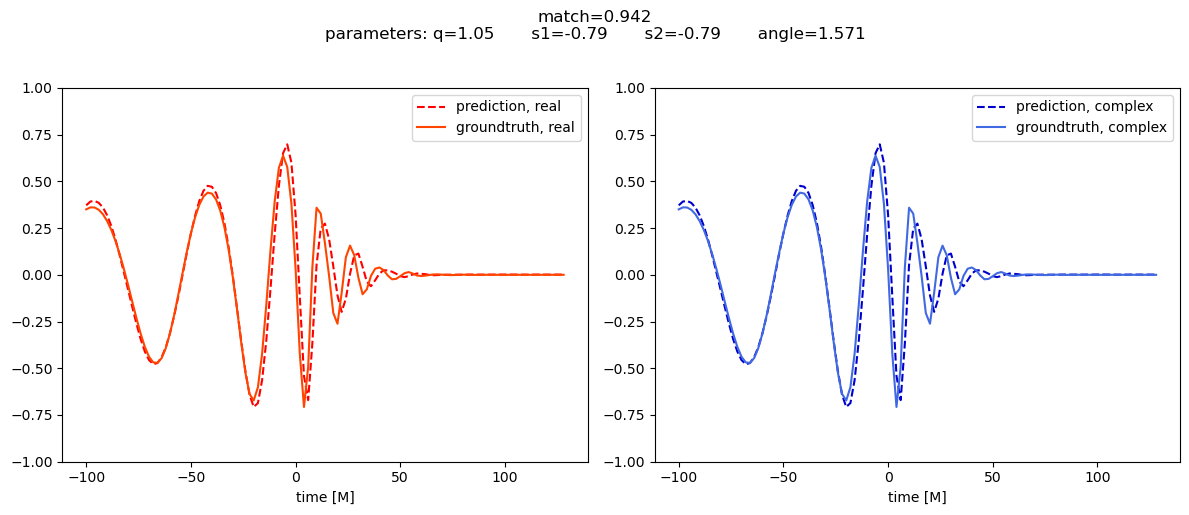

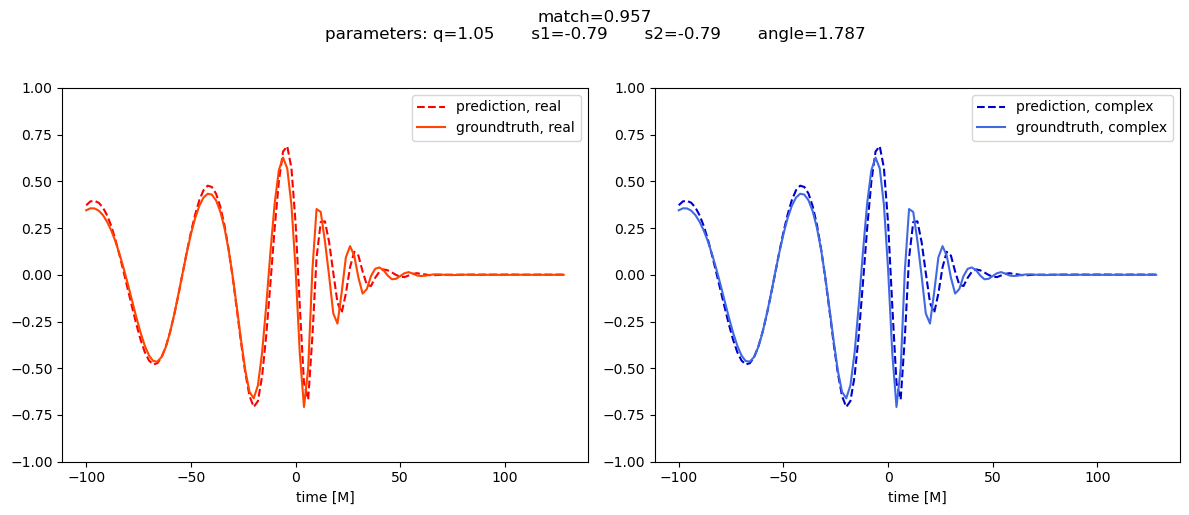

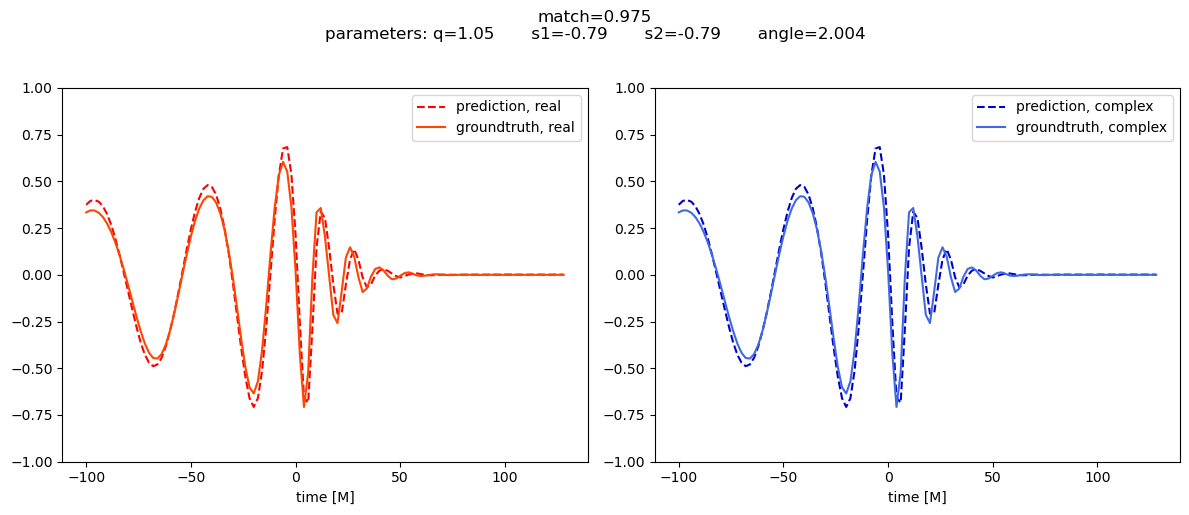

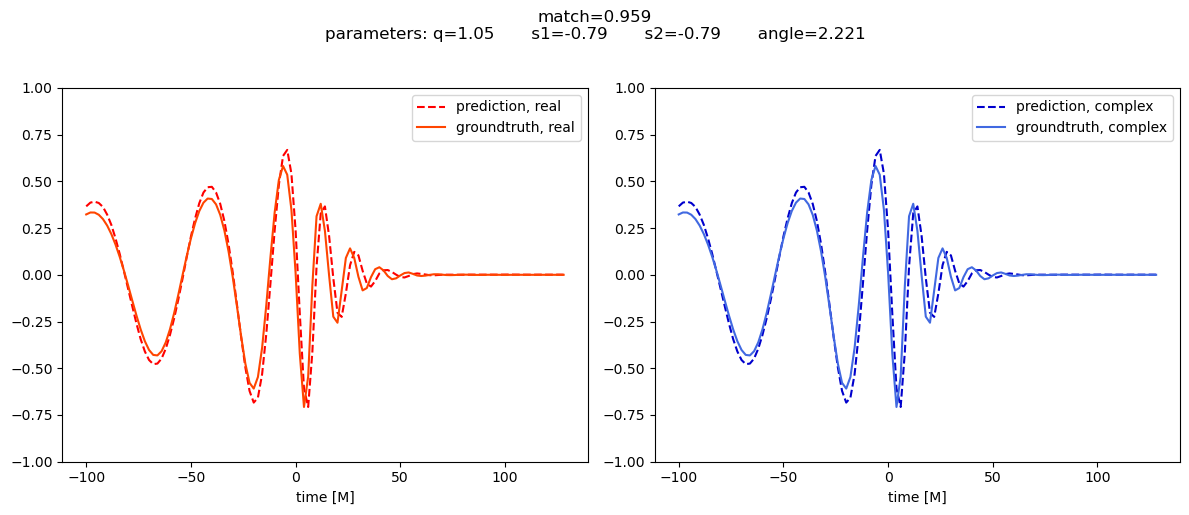

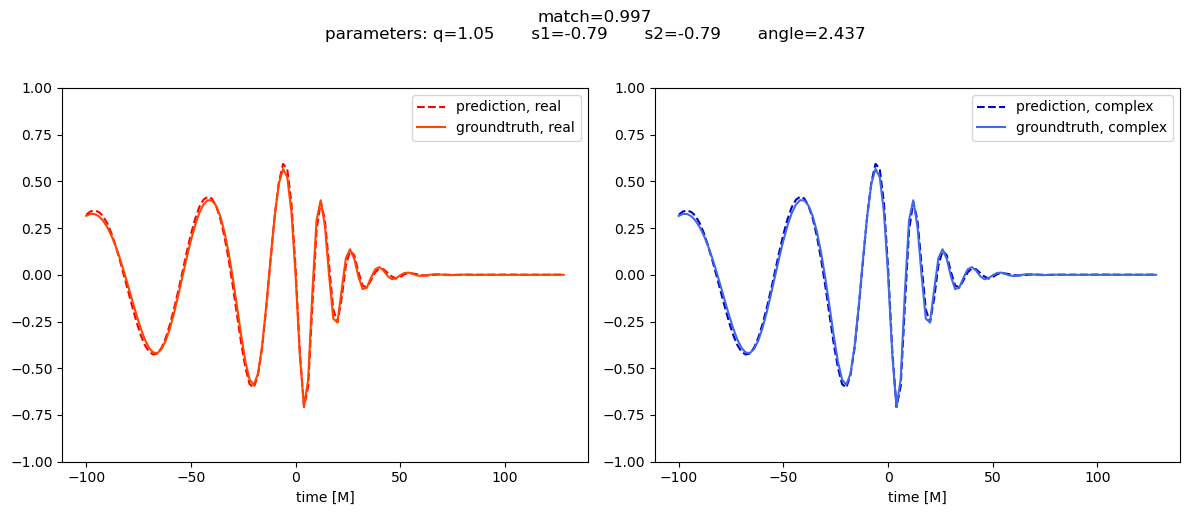

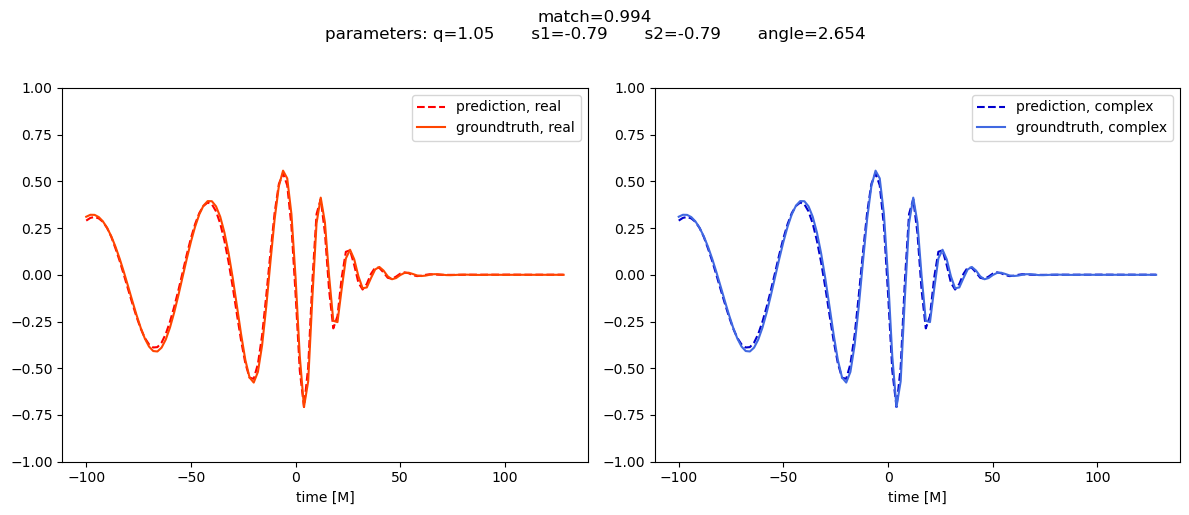

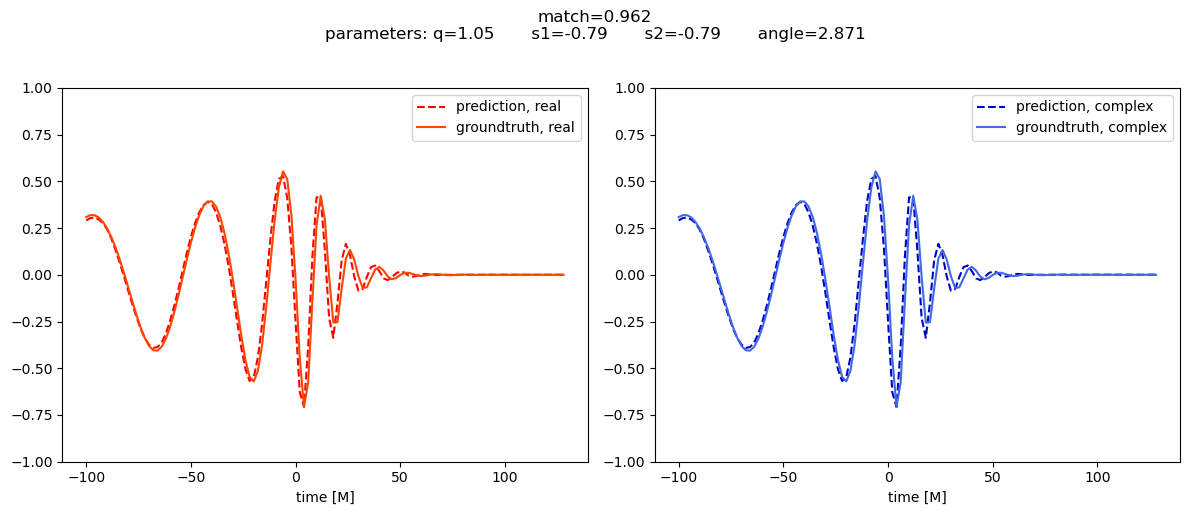

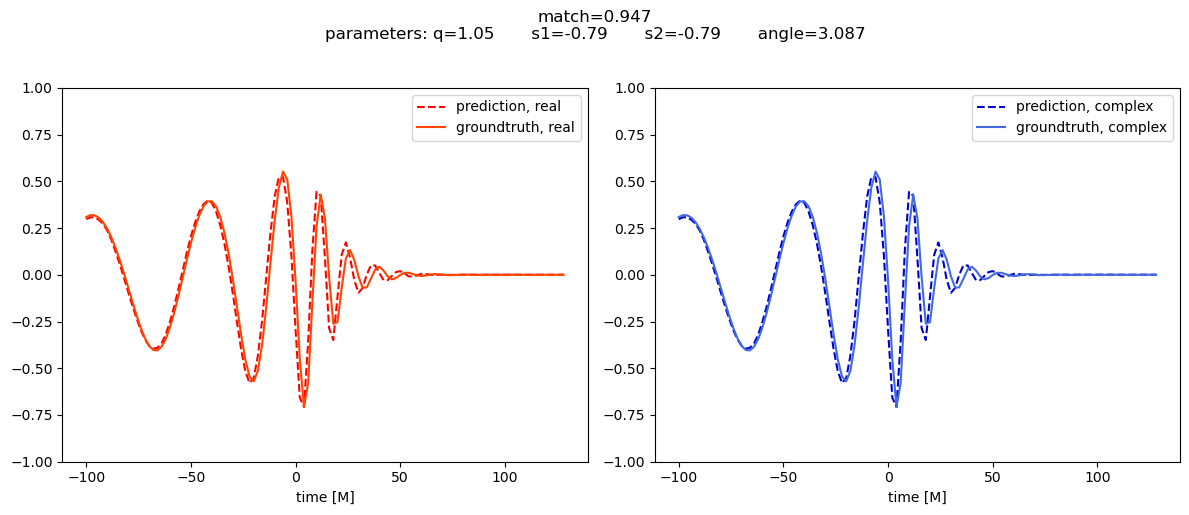

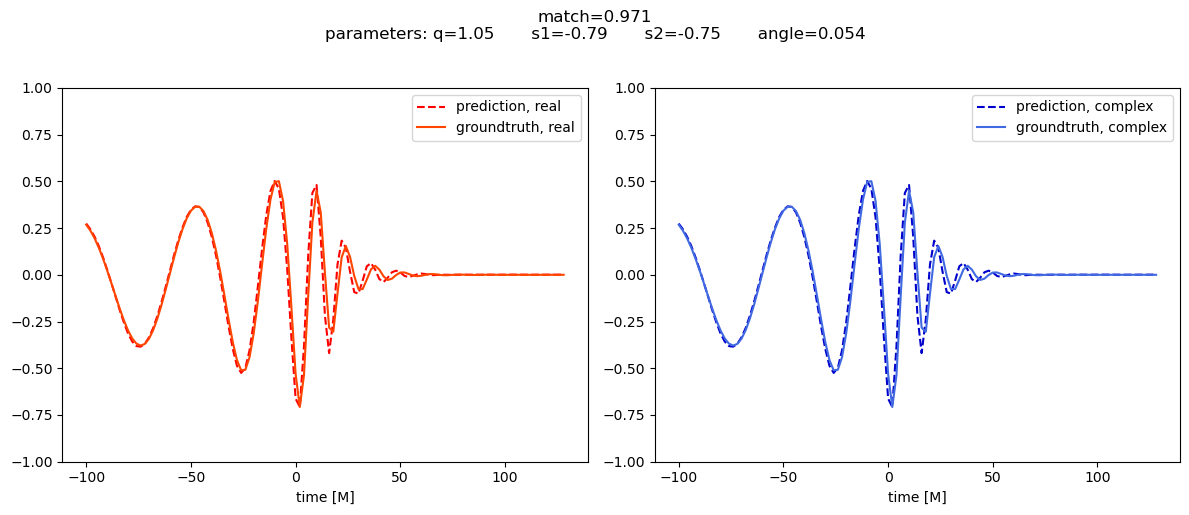

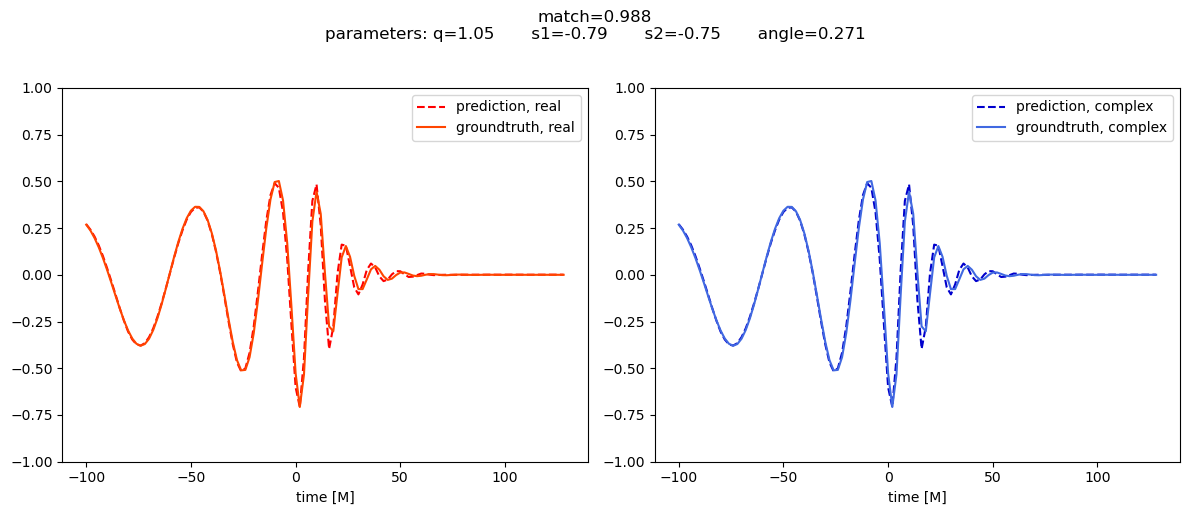

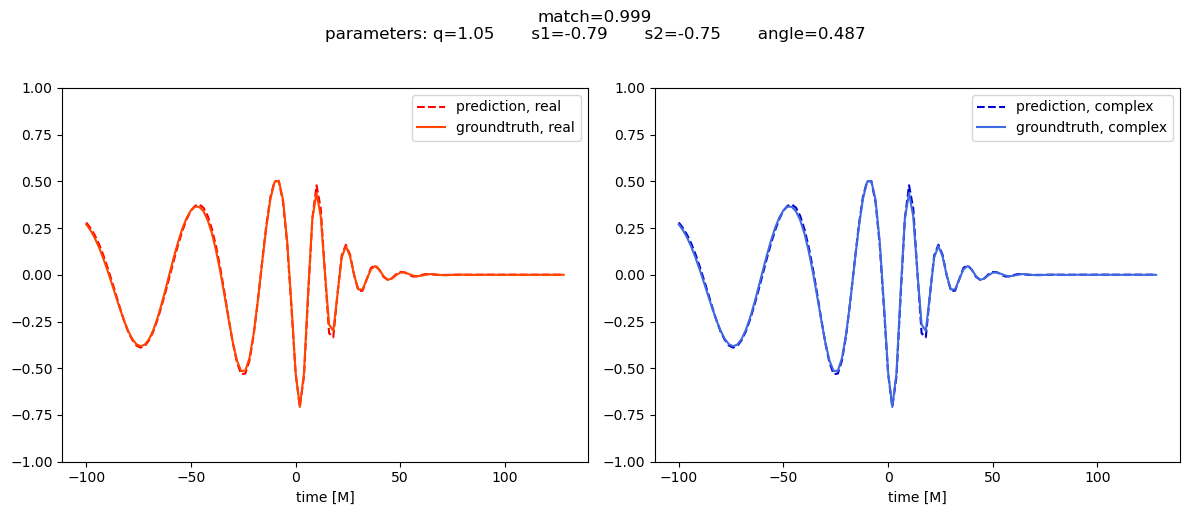

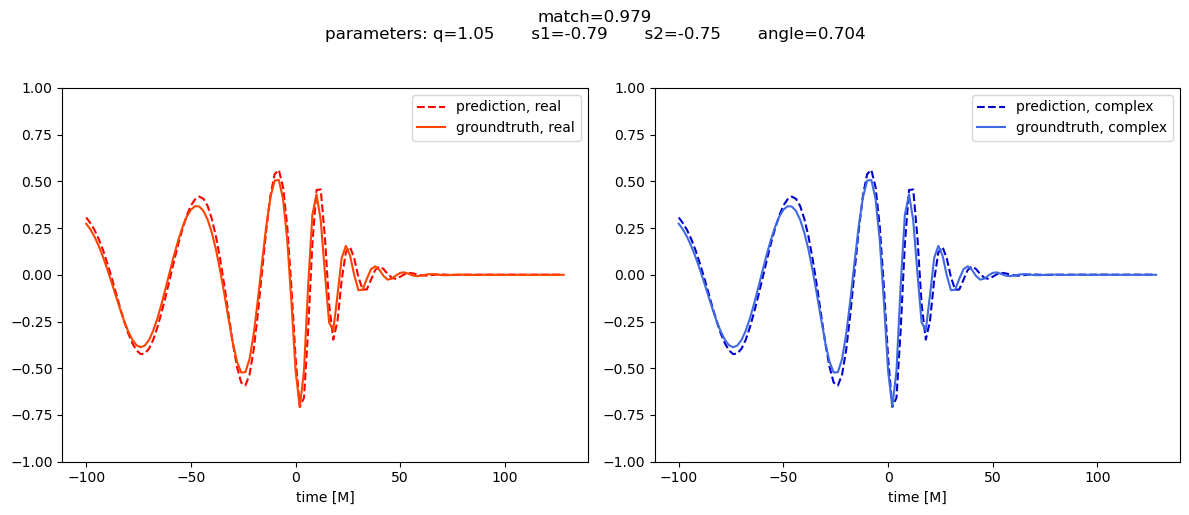

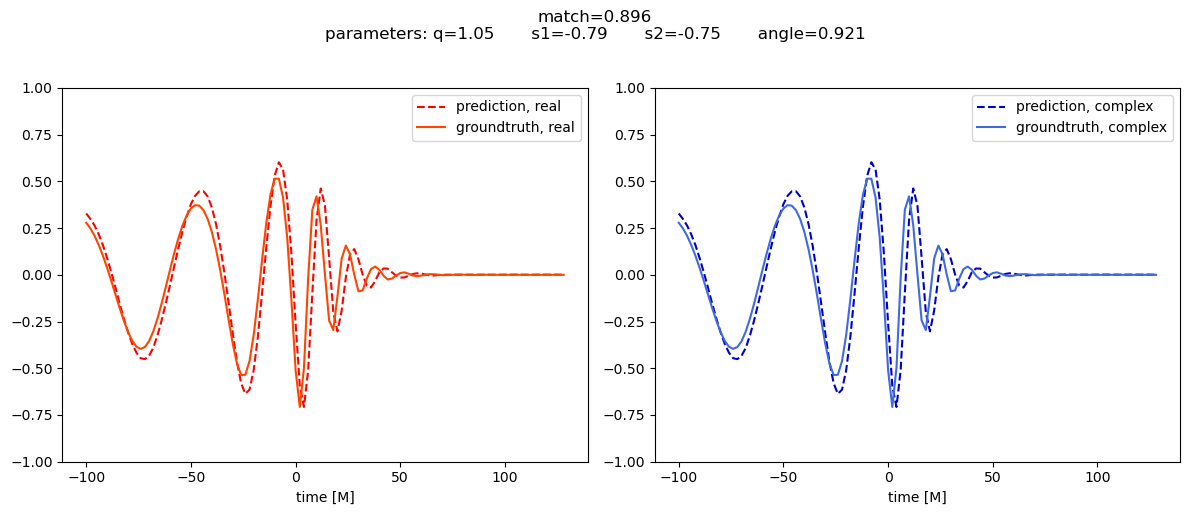

In [9]:
def plot_overlaps(idx):
    wf_l = targets[idx].copy()
    wf_p = predictions[idx].copy()

    #wf_l = wf_l.real + 0*1j
    #wf_p = wf_p.real + 0*1j

    times = np.arange(-10_000, 130, 1); times = times[::2]; t = times[-95:]

    wave_length = len(wf_l)
    t = times[:wave_length]

    wf_l,wf_p,match = align_normalize_and_match(wf_l, wf_p, t)

    # Extracting individual components of params[idx]
    q, s1, s2, angle = map(float, params[idx])
    match=round(match,3)
    q = round(q, 3)
    s1 = round(s1, 3)
    s2 = round(s2, 3)
    angle = round(angle, 3)

    # Plotting real part
    plt.figure(figsize=(12, 5))  # Adjust the figure size as needed

    plt.subplot(1, 2, 1)
    plt.plot(times[-len(wf_l):], wf_p.real, '--',c='r', label='prediction, real')
    plt.plot(times[-len(wf_l):], wf_l.real, c='orangered', label='groundtruth, real')
    plt.ylim([-1,1])
    plt.legend()
    plt.xlabel('time [M]')

    # Plotting imaginary part
    plt.subplot(1, 2, 2)
    plt.plot(times[-len(wf_l):], wf_p.imag, '--',c='mediumblue', label='prediction, complex')
    plt.plot(times[-len(wf_l):], wf_l.imag,  c='royalblue', label='groundtruth, complex')
    plt.ylim([-1,1])
    plt.legend()
    plt.xlabel('time [M]')
    
    # Creating the combined title
    combined_title = (
        f"match={match}\n"
        f"parameters: q={q:<10} s1={s1:<10}  s2={s2:<10}  angle={angle}"
    )

    # Setting the combined title for both subplots
    plt.suptitle(combined_title, y=1.02, fontsize=12)  # y parameter adjusts vertical spacing

    plt.tight_layout()  # Adjusts spacing between subplots
    plt.show()
    
for i in range (20):
    idx = i#np.random.randint(0,predictions.shape[0])
    plot_overlaps(idx)
    #idx=np.where( Ms < .28 )[i]

#### b) All dataset

In [10]:
import multiprocessing

In [11]:
# Convert waveforms to complex arrays and compute match
def compute_match(idx):
    
    wf_l = targets[idx].copy()
    wf_p = predictions[idx].copy()
    
    # Define the times array
    times = np.arange(-10_000, 130, 1); times = times[::2]; t = times[-95:]
    wave_length = len(wf_l)
    t = times[:wave_length]
    
    wf_l = targets[idx]
    wf_p = predictions[idx]
    
    #wf_l = wf_l + 0*1j
    #wf_p = wf_p + 0*1j

    match = align_normalize_and_match(wf_l, wf_p, t)[2]
    return match


# Parallelize the computation
def compute_match_in_parallel(indices):
    
    with multiprocessing.Pool(processes=32) as pool:
        Ms = pool.map(compute_match, indices)
        
    return np.array(Ms)

In [12]:
%%time

if __name__=='__main__':
    
    indices = np.arange(targets.shape[0]) #np.arange(0,10_000)
    Ms = compute_match_in_parallel(indices)

CPU times: user 257 ms, sys: 15.5 ms, total: 273 ms
Wall time: 592 ms


In [13]:
np.median(Ms)

0.9739359370704201

In [14]:
# Save the predictions

#np.save(checkpoint_dir+'complex_match.npy', Ms)

In [15]:
#Ms = np.load(checkpoint_dir+'complex_match.npy')


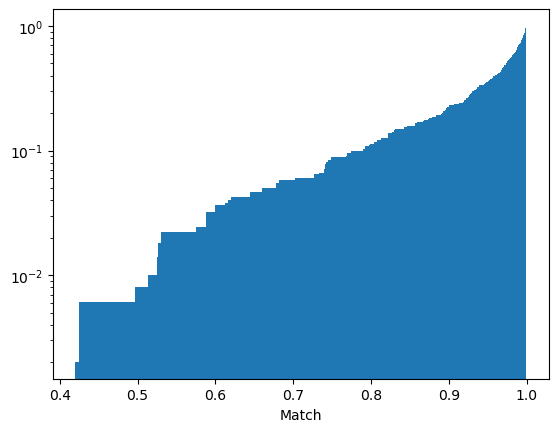

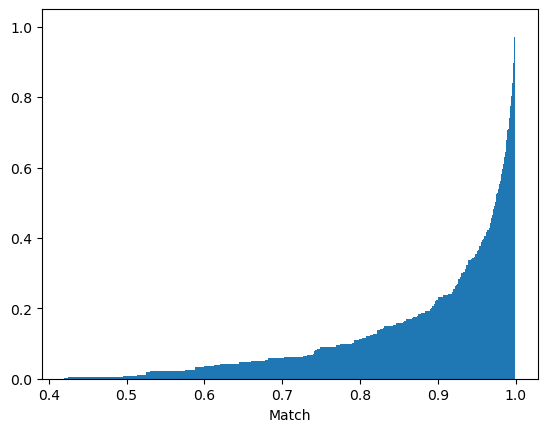

In [16]:
plt.hist(np.abs(Ms), bins=1000, cumulative=True,density=True)
plt.yscale('log')
plt.xlabel('Match')
#plt.xlim([0.9,1])
plt.show()

plt.hist(np.abs(Ms), bins=1000, cumulative=True,density=True)
plt.xlabel('Match')
#plt.xlim([0.9,1])
plt.show()

In [17]:
delta_pi=np.pi/4.0
M_max=5.

mask_0th = params[:,0, 0] < M_max
mask_3rd = (params[:,0, 3] < np.pi/2.0-delta_pi) | (params[:,0, 3] > np.pi/2.0+delta_pi)

# Combine the masks using logical AND
final_mask = mask_0th & mask_3rd

# Apply the mask to Ms
filtered_Ms = Ms[final_mask]

# Plot the histogram
plt.hist(filtered_Ms, bins=1000, cumulative=True, density=True)
plt.title(f'match values for waveforms with M < {M_max} and phi < {round(np.pi/2 - delta_pi,3)} and phi > {round(np.pi/2 + delta_pi,3)}')
plt.show()

plt.hist(np.abs(filtered_Ms), bins=1000, cumulative=True,density=True)
plt.yscale('log')
plt.title(f'match values for waveforms with M < {M_max} and phi < {round(np.pi/2 - delta_pi,3)} and phi > {round(np.pi/2 + delta_pi,3)}')
plt.show()

print(np.median(filtered_Ms))

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

In [21]:
s=.99
print('\nnumber of matches over  '+str(s)+': '+str((Ms > s).sum()))
print('percent matches over '+str(s)+': '+str((Ms > s).sum() / Ms.shape[0] * 100))
#print('percent matches over '+str(s)+': '+str((Ms > s).sum() / Ms.shape[0]  * 100))

s=.99
print('\nnumber of matches below '+str(s)+': '+str((Ms < s).sum()))
print('percent matches under '+str(s)+': '+str((Ms < s).sum() / Ms.shape[0] * 100))
#print('percent matches over '+str(s)+': '+str((Ms > s).sum() / Ms.shape[0]  * 100))

s=.98
print('\nnumber of matches below '+str(s)+': '+str((Ms < s).sum()))
print('percent matches under '+str(s)+': '+str((Ms < s).sum() / Ms.shape[0] * 100))
#print('percent matches over '+str(s)+': '+str((Ms > s).sum() / Ms.shape[0]  * 100))

s=.95
print('\nnumber of matches below '+str(s)+': '+str((Ms < s).sum()))
print('percent matches under '+str(s)+': '+str((Ms < s).sum() / Ms.shape[0] * 100))
#print('percent matches over '+str(s)+': '+str((Ms > s).sum() / Ms.shape[0]  * 100))

s=.9
print('\nnumber of matches below '+str(s)+': '+str((Ms < s).sum()))
print('percent matches under '+str(s)+': '+str((Ms < s).sum() / Ms.shape[0] * 100))
#print('percent matches over '+str(s)+': '+str((Ms > s).sum() / Ms.shape[0]  * 100))

s=.8
print('\nnumber of matches below '+str(s)+': '+str((Ms < s).sum()))
print('percent matches under '+str(s)+': '+str((Ms < s).sum() / Ms.shape[0] * 100))
#print('percent matches over '+str(s)+': '+str((Ms > s).sum() / Ms.shape[0]  * 100))


number of matches over  0.99: 146
percent matches over 0.99: 29.435483870967744

number of matches below 0.99: 350
percent matches under 0.99: 70.56451612903226

number of matches below 0.98: 277
percent matches under 0.98: 55.846774193548384

number of matches below 0.95: 176
percent matches under 0.95: 35.483870967741936

number of matches below 0.9: 111
percent matches under 0.9: 22.379032258064516

number of matches below 0.8: 56
percent matches under 0.8: 11.29032258064516


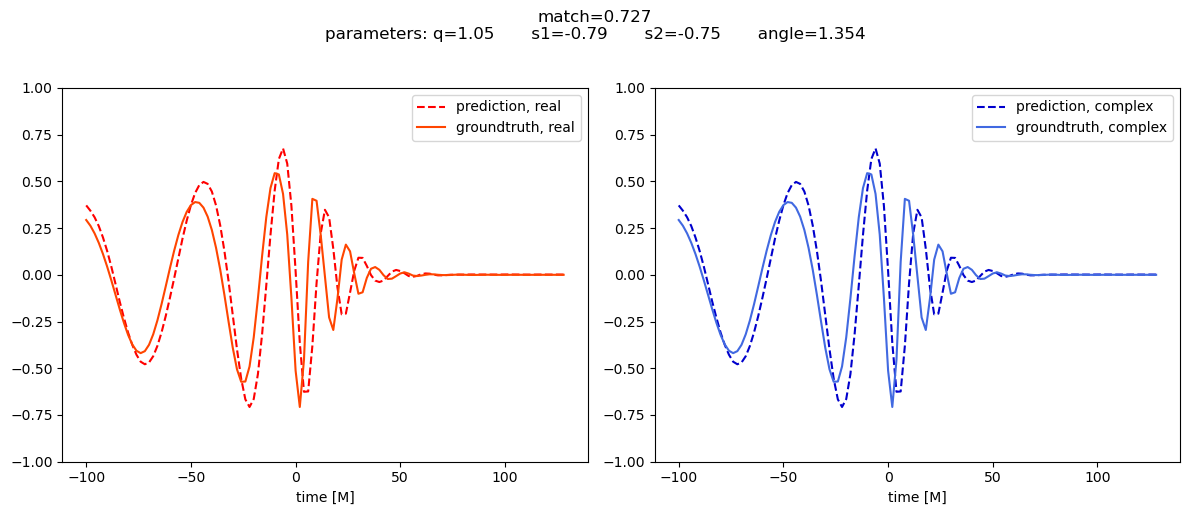

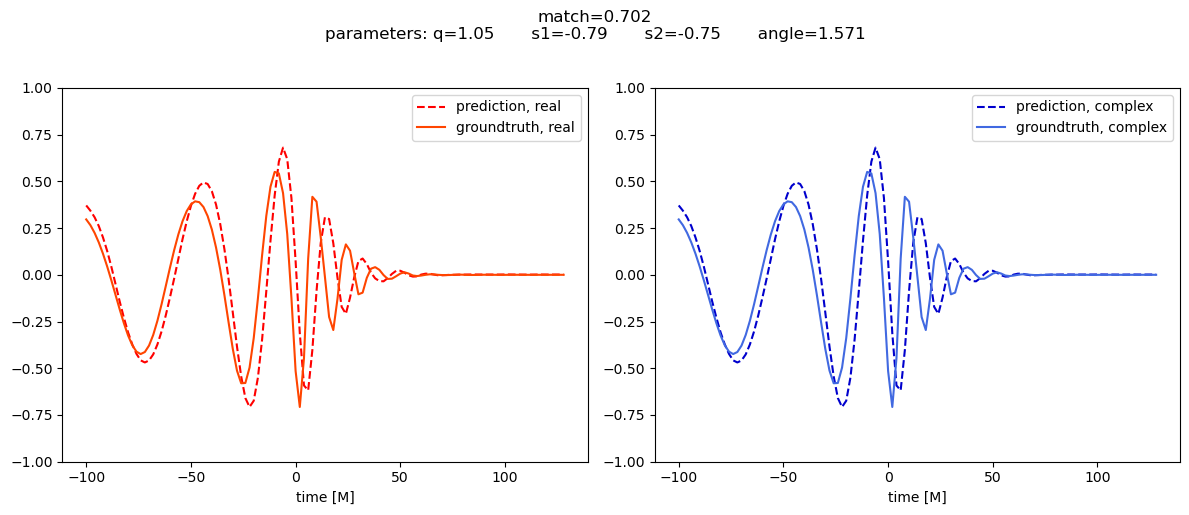

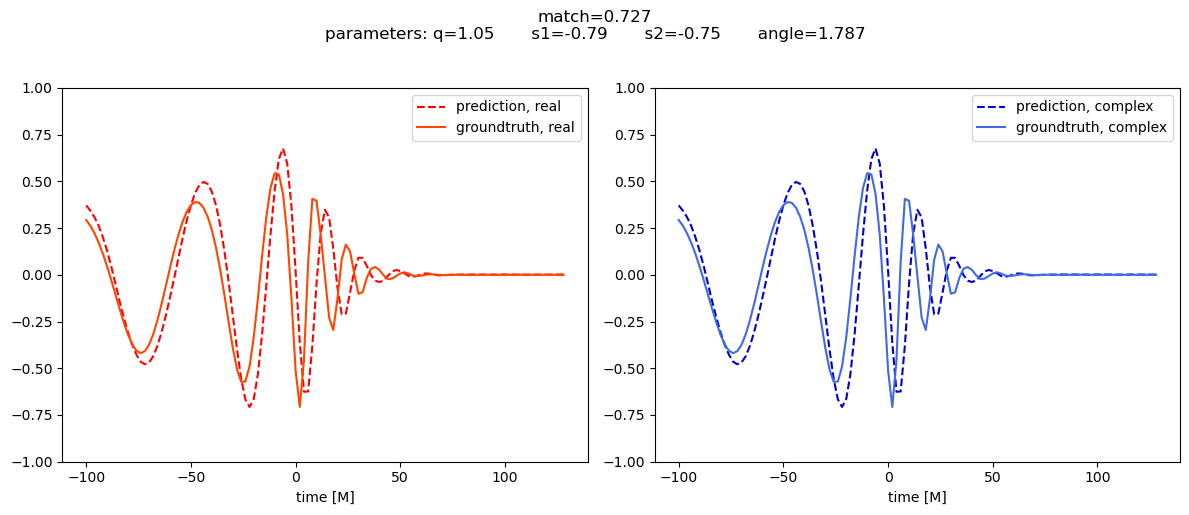

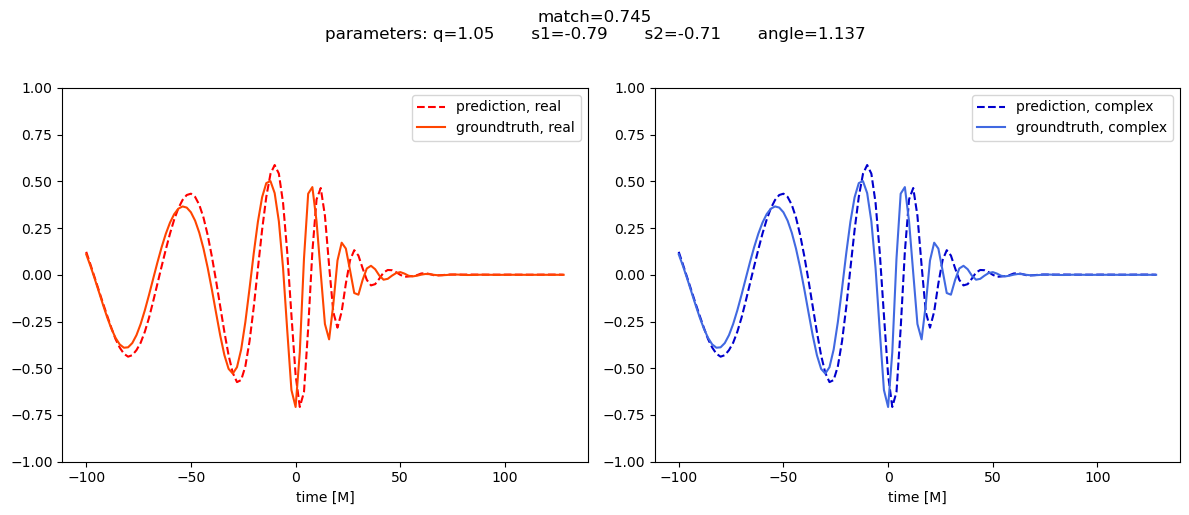

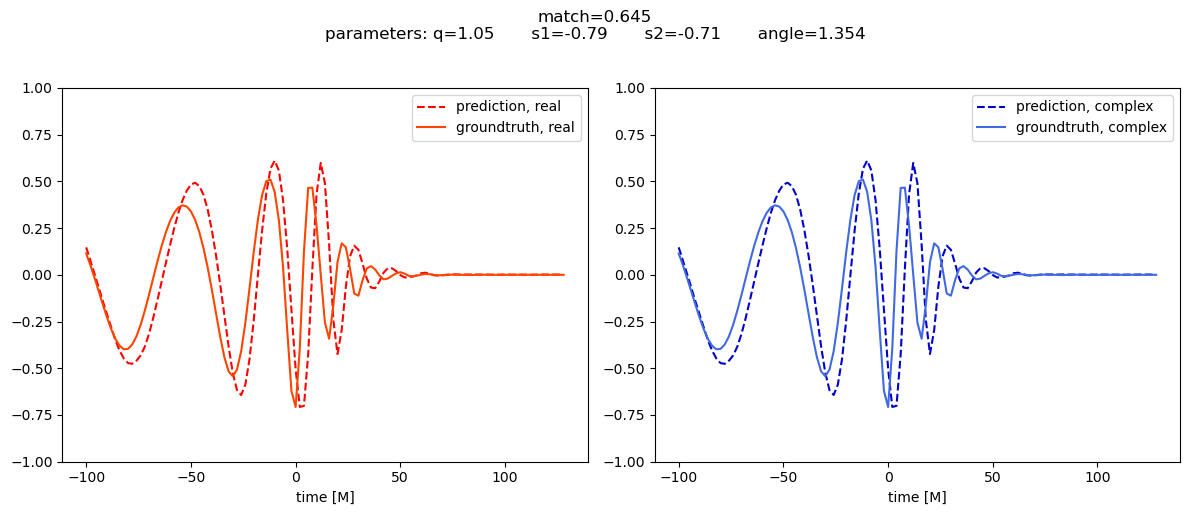

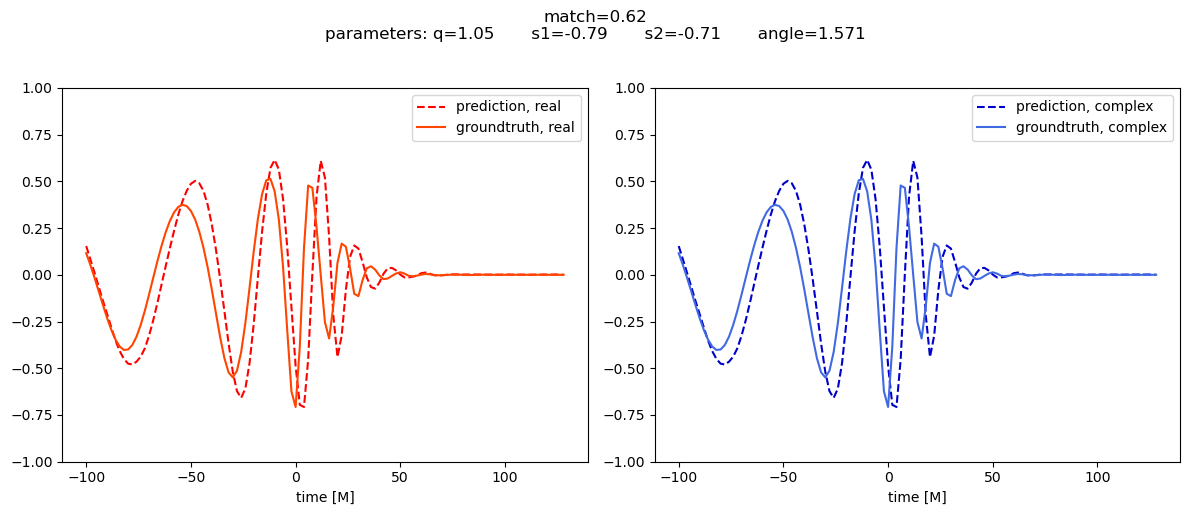

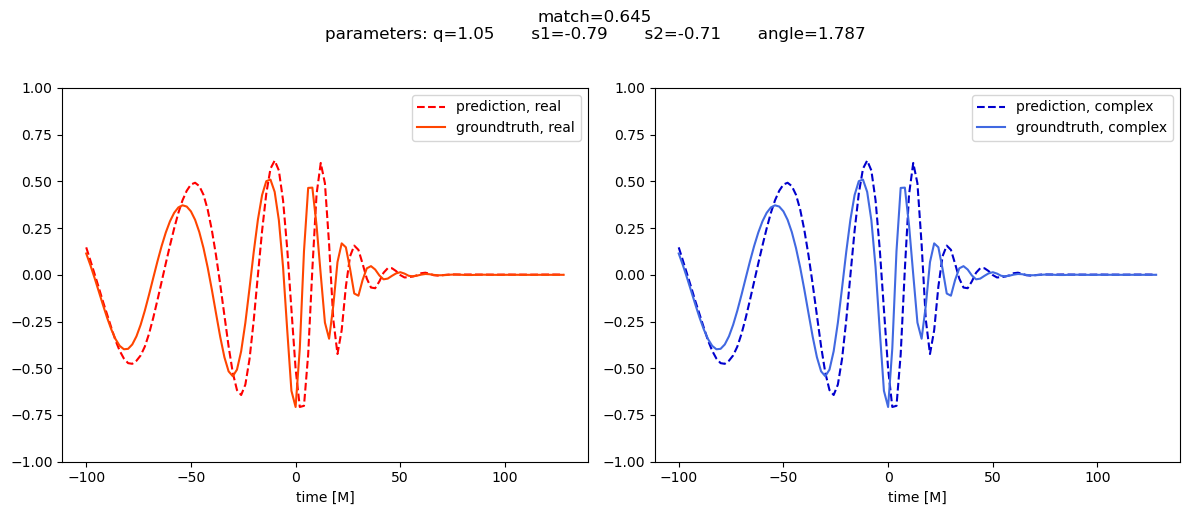

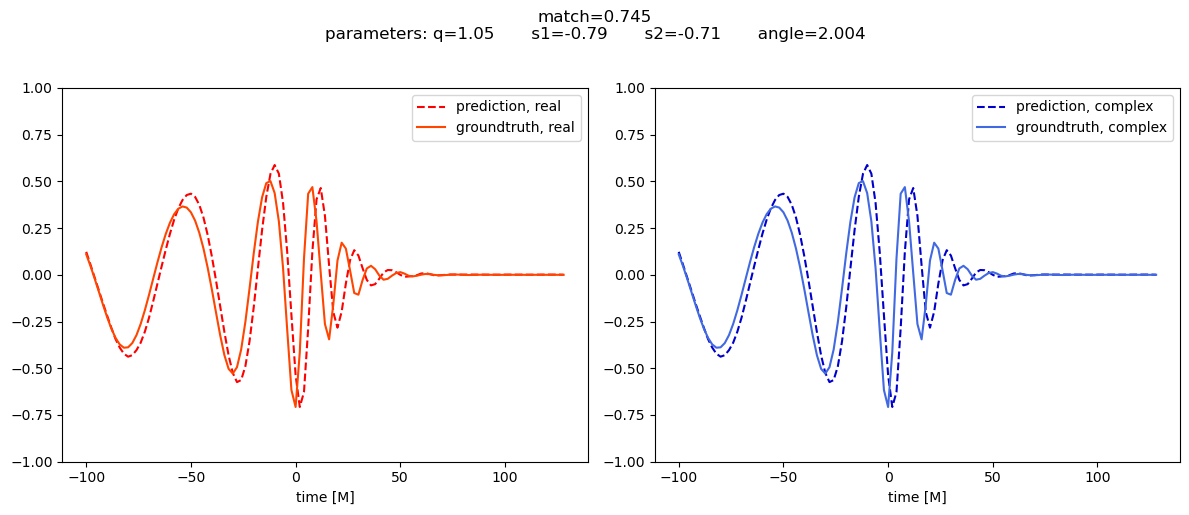

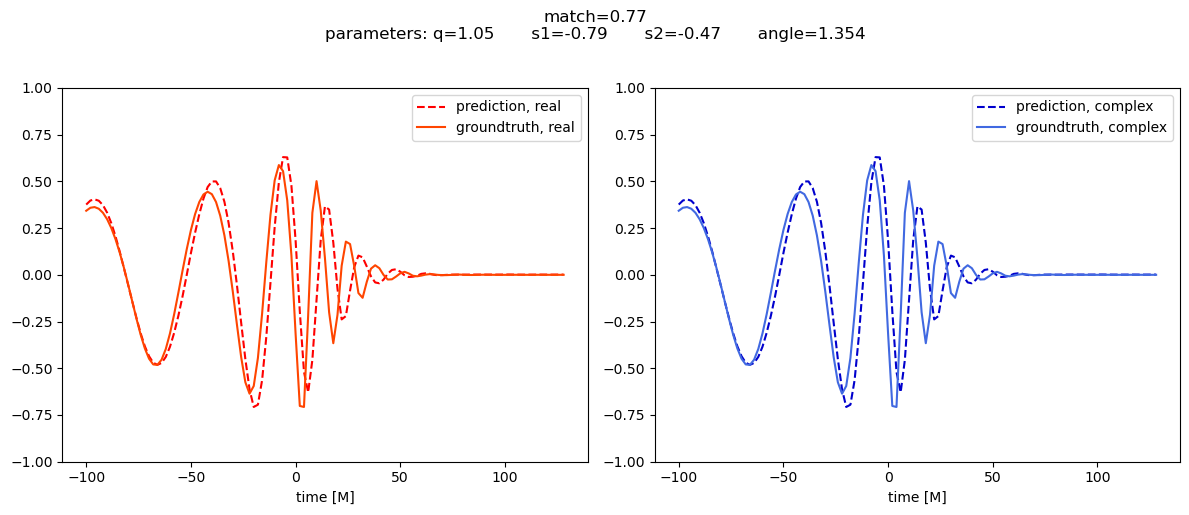

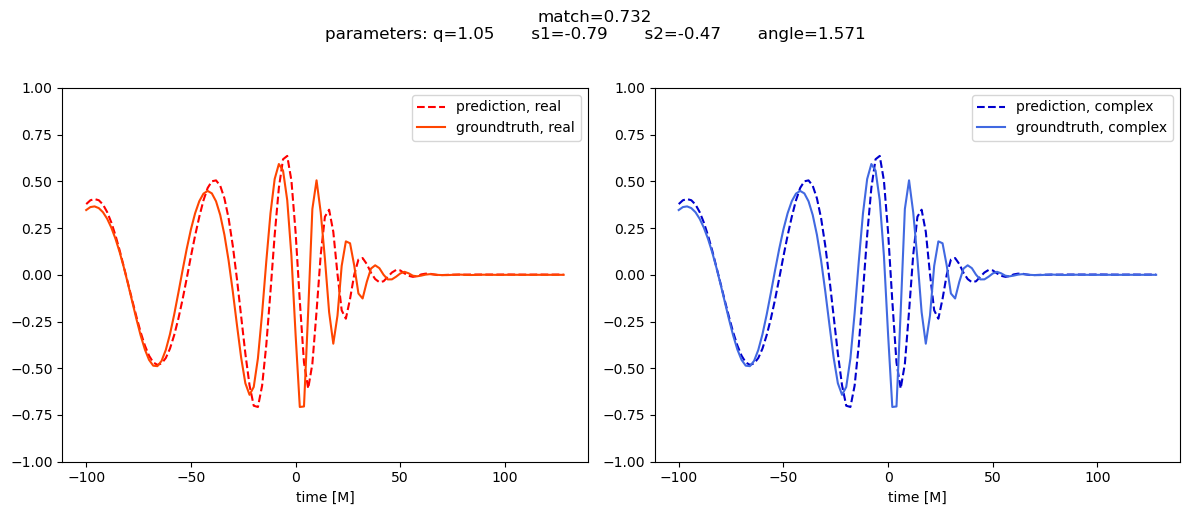

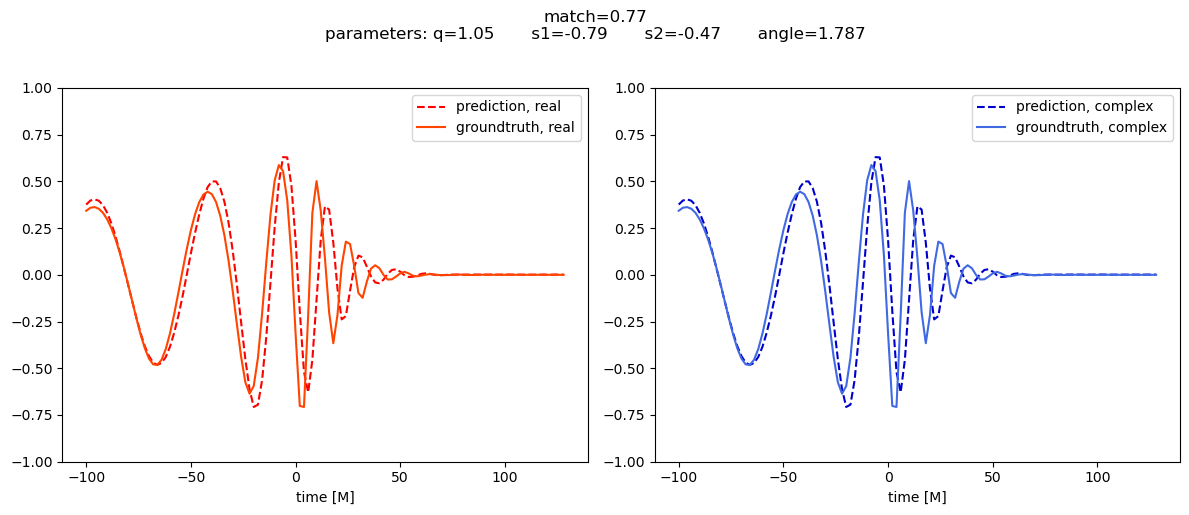

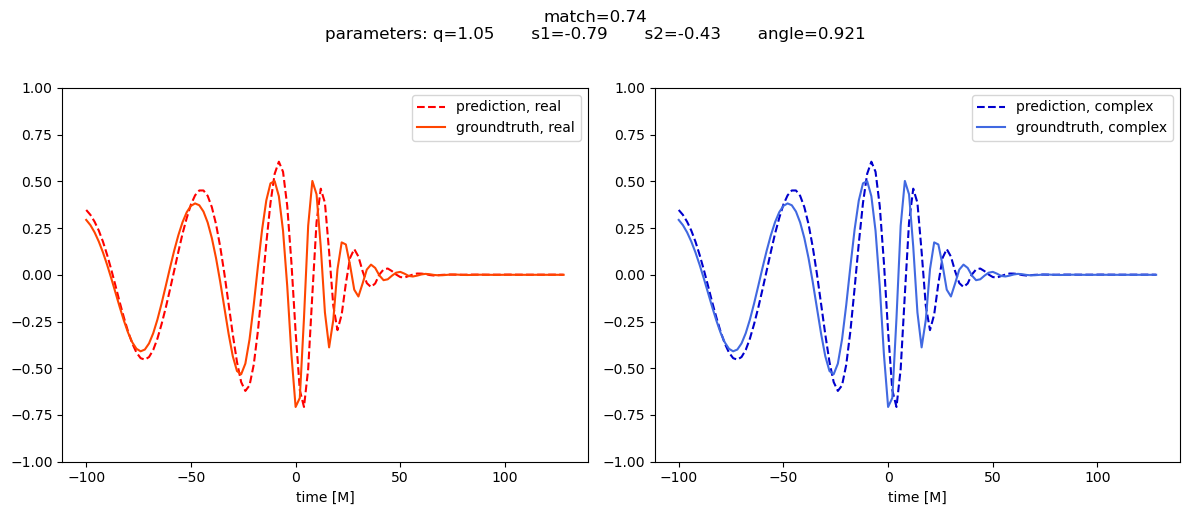

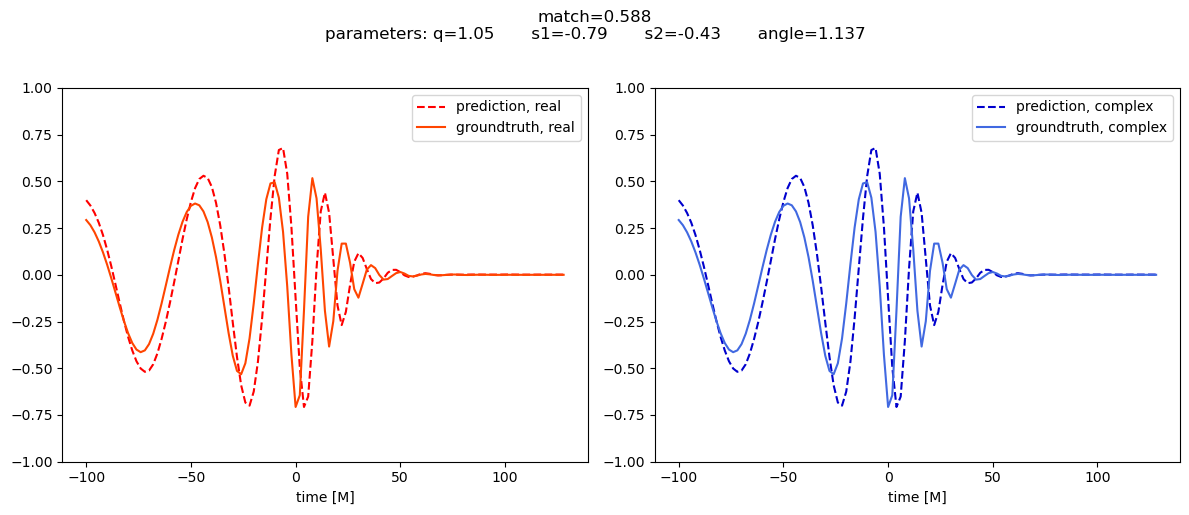

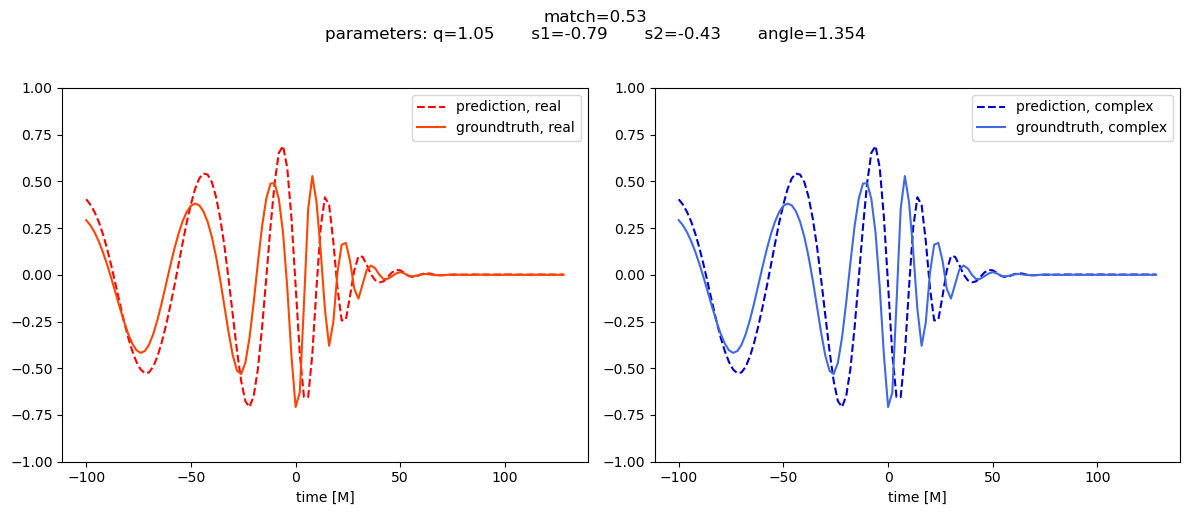

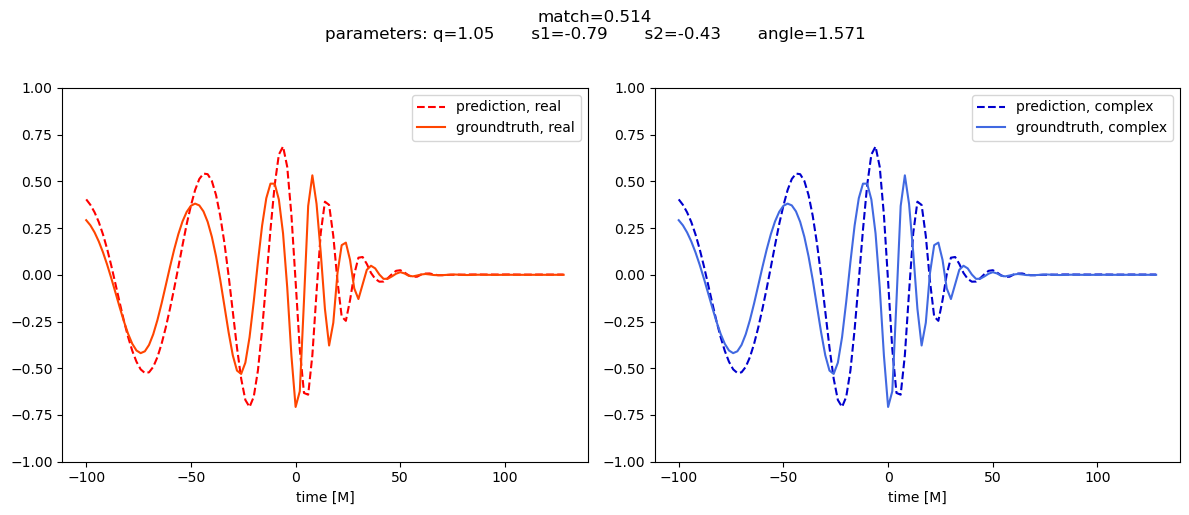

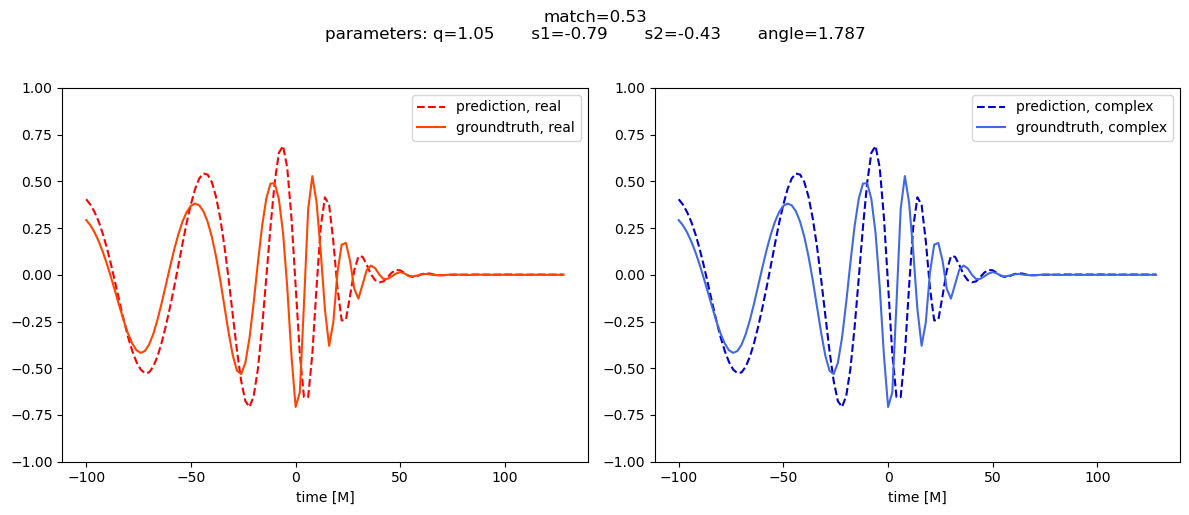

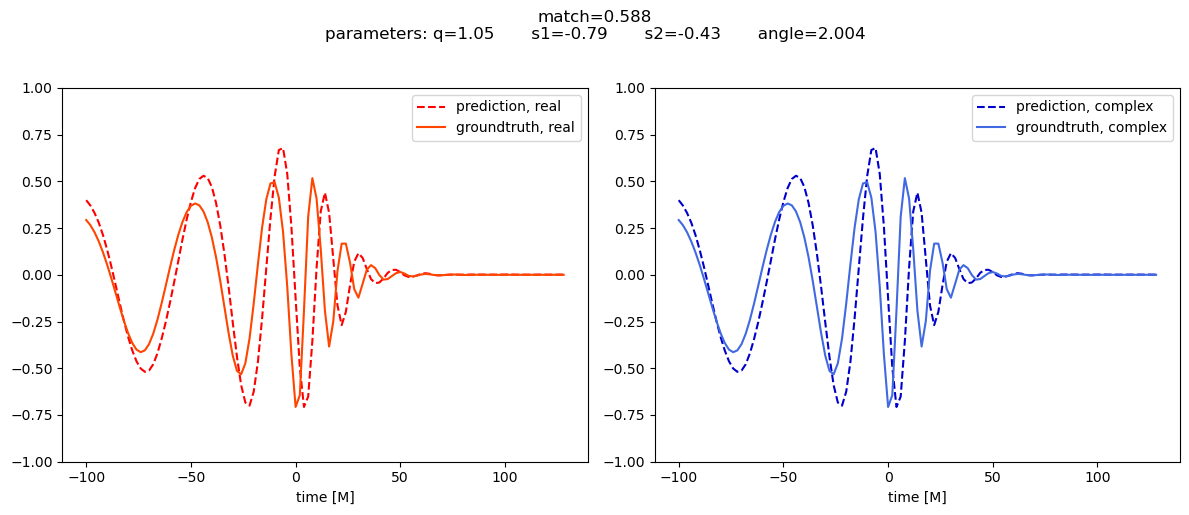

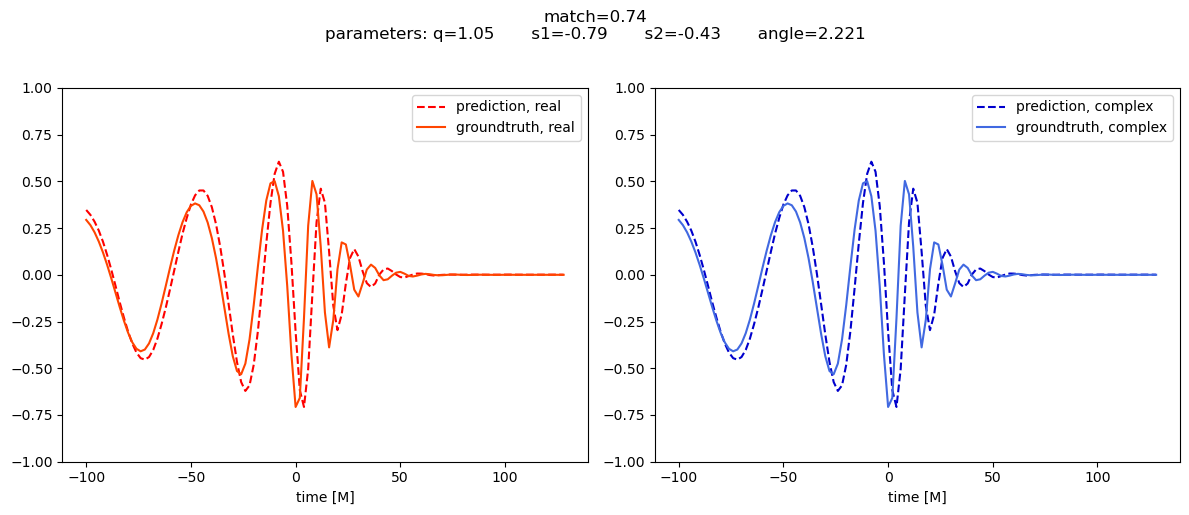

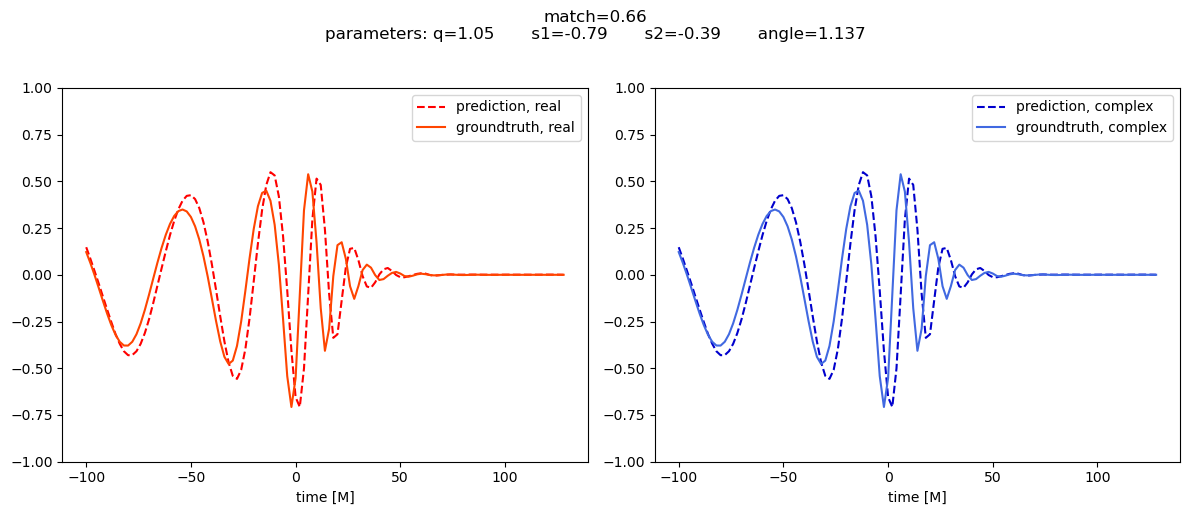

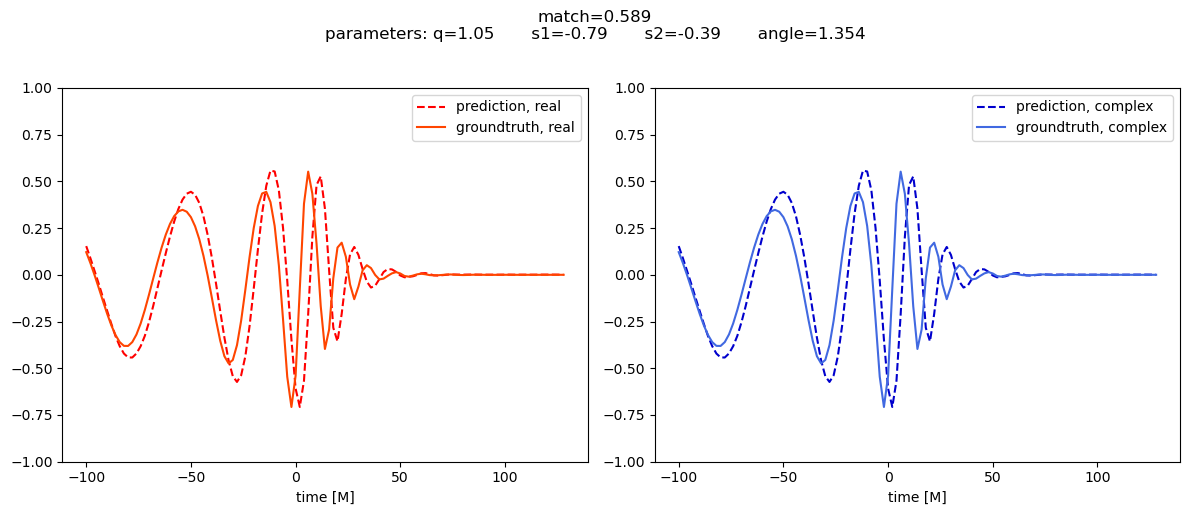

In [19]:
for i in range (0,min(20,np.shape(np.where(Ms < .8)[0])[0])):
    plot_overlaps(np.where( Ms < .8)[0][i])

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

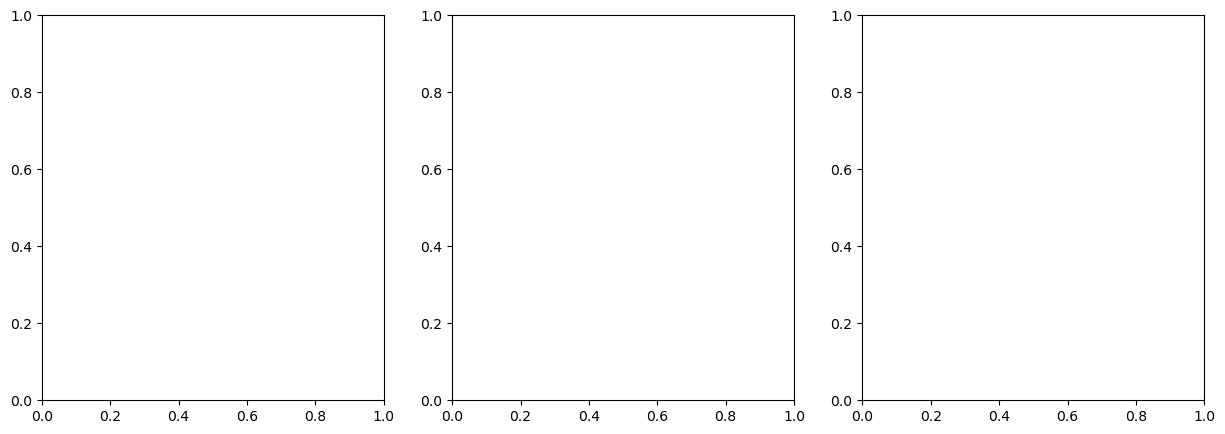

In [20]:
s=[0.99,0.98,0.9]
for i in range(0,len(s)):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    

    # Plot 1
    axs[0].hist(params[np.where(Ms < s[i])[0]][:,0, 0])
    axs[0].set_xlabel('mass ratio q for matches worse than ' + str(s[i]))
    axs[0].set_xlim([1, 8])

    # Plot 2
    spin_eff = (params[np.where(Ms < s[i])[0]][:,0, 0] * params[np.where(Ms < s[i])[0]][:,0, 1] + params[np.where(Ms < s[i])[0]][:,0, 2]) / (1 + params[np.where(Ms < s[i])[0]][:,0, 0])
    axs[1].hist(spin_eff)
    axs[1].set_xlabel('effective spin for matches worse than ' + str(s[i]))
    axs[1].set_xlim([-0.8, 0.8])

    # Plot 3
    axs[2].hist(params[np.where(Ms < s[i])[0]][:,0, 3])
    axs[2].set_xlabel('inclination angle for matches worse than ' + str(s[i]))
    axs[2].set_xlim([0, np.pi])

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()


In [ ]:
import seaborn as sns

s=[1.0001,0.99,0.98,0.95,0.9,0.8]
for i in range(0,len(s)):

    fig, axs = plt.subplots(1, 3, figsize=(18, 6))

    spin_eff = (params[np.where(Ms < s[i])[0]][:,0, 0] * params[np.where(Ms < s[i])[0]][:,0, 1] + params[np.where(Ms < s[i])[0]][:,0, 2]) / (1 + params[np.where(Ms < s[i])[0]][:,0, 0])
    sns.kdeplot(params[np.where(Ms < s[i])[0]][:, 0, 0], spin_eff, cmap='Blues', ax=axs[0], shade=True, cbar=True)    
    axs[0].set_xlabel('mass ratio q')
    axs[0].set_ylabel('effective spin')
    axs[0].set_xlim([1,8])
    axs[0].set_ylim([-0.8,.8])

    sns.kdeplot(spin_eff, params[np.where(Ms < s[i])[0]][:, 0, 3], cmap='Greens', ax=axs[1], shade=True, cbar=True)
    axs[1].set_xlabel('effective spin')
    axs[1].set_ylabel('inclination angle')
    axs[1].set_ylim([0,np.pi])
    axs[1].set_xlim([-0.8,.8])

    sns.kdeplot(params[np.where(Ms < s[i])[0]][:, 0, 0], params[np.where(Ms < s[i])[0]][:, 0, 3], cmap='Reds', ax=axs[2], shade=True, cbar=True)
    axs[2].set_xlabel('mass ratio q')
    axs[2].set_ylabel('inclination angle')
    axs[2].set_ylim([0,np.pi])
    axs[2].set_xlim([1,8])

    common_title = '2D Histogram for matches worse than ' + str(s[i])
    fig.suptitle(common_title, fontsize=16)

    #cbar_1_2 = plt.colorbar(hist_1_2[3], ax=axs[0])
    #cbar_2_3 = plt.colorbar(hist_2_3[3], ax=axs[1])
    #cbar_1_3 = plt.colorbar(hist_1_3[3], ax=axs[2])

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


In [ ]:
s = [1.0001, 0.99, 0.98, 0.95, 0.9, 0.8]

for i in range(0, len(s)):
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))

    spin_eff = (params[np.where(Ms < s[i])[0]][:, 0, 0] * params[np.where(Ms < s[i])[0]][:, 0, 1] + params[np.where(Ms < s[i])[0]][:, 0, 2]) / (1 + params[np.where(Ms < s[i])[0]][:, 0, 0])

    # Create 2D density plots with discrete bins and normalized values
    hist_1_2, xedges, yedges = np.histogram2d(params[np.where(Ms < s[i])[0]][:, 0, 0], spin_eff, bins=20, density=True)
    axs[0].imshow(hist_1_2.T, cmap='Blues', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1],])
    axs[0].set_xlabel('mass ratio q')
    axs[0].set_ylabel('effective spin')
    axs[0].set_xlim([1, 8])
    axs[0].set_ylim([-0.8, 0.8])

    hist_2_3, xedges, yedges = np.histogram2d(spin_eff, params[np.where(Ms < s[i])[0]][:, 0, 3], bins=20, density=True)
    axs[1].imshow(hist_2_3.T, cmap='Greens', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
    axs[1].set_xlabel('effective spin')
    axs[1].set_ylabel('inclination angle')
    axs[1].set_ylim([0, np.pi])
    axs[1].set_xlim([-0.8, 0.8])

    hist_1_3, xedges, yedges = np.histogram2d(params[np.where(Ms < s[i])[0]][:, 0, 0], params[np.where(Ms < s[i])[0]][:, 0, 3], bins=20, density=True)
    axs[2].imshow(hist_1_3.T, cmap='Reds', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
    axs[2].set_xlabel('mass ratio q')
    axs[2].set_ylabel('inclination angle')
    axs[2].set_ylim([0, np.pi])
    axs[2].set_xlim([1, 8])

    common_title = '2D Density Plot for matches worse than ' + str(s[i])
    fig.suptitle(common_title, fontsize=16)

    cbar_1_2 = plt.colorbar(axs[0].images[0], ax=axs[0])
    cbar_2_3 = plt.colorbar(axs[1].images[0], ax=axs[1])
    cbar_1_3 = plt.colorbar(axs[2].images[0], ax=axs[2])

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


In [ ]:
def spin_eff(q, s1, s2):   
    return (q * s1 + s2) / (1 + q),s1,s2

def plot_2dhist(q):
    num_bins=100
    s1_range = [-0.8, 0.8]
    s2_range = [-0.8, 0.8]
    
    s1_values = np.linspace(s1_range[0], s1_range[1], num_bins)
    s2_values = np.linspace(s2_range[0], s2_range[1], num_bins)
    s1_grid, s2_grid = np.meshgrid(s1_values, s2_values)
    
    spin_eff_values,s1_values,s2_values = spin_eff(q, s1_grid, s2_grid)
    
    plt.figure(figsize=(8, 6))
    plt.contourf(s1_values, s2_values, spin_eff_values)
    plt.colorbar()
    plt.xlabel('s1')
    plt.ylabel('s2')
    plt.title(f'2D Histogram of spin_eff (q={q})')
    plt.show()

plot_2dhist(q=8)